In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv

%matplotlib inline

In [2]:
X_train = []
Y_train = []
X_test = []

with open('train.csv', 'r') as train_file:
    reader = csv.reader(train_file)
    next(reader)
    for row in reader:
        Y_train.append(int(row[0]))
        X_train.append(list(map(int, row[1:])))

with open('test.csv', 'r') as test_file:
    reader = csv.reader(test_file)
    next(reader)
    for row in reader:
        X_test.append(list(map(int, row)))

X_train = np.array(X_train).T
Y_train = np.array(Y_train).reshape(1, -1)
X_test = np.array(X_test).T

print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (784, 42000)
Shape of Y_train: (1, 42000)
Shape of X_test: (784, 28000)


This digit is 7


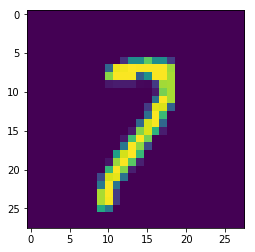

In [3]:
index = 29498
plt.imshow(X_train[:, index].reshape(28, 28))
print('This digit is', Y_train[0, index])

In [4]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    return X,Y

In [5]:
def initialize_parameters(layers_dims):
    L = len(layers_dims)
    parameters = {}
    for l in range(1, L):
        parameters['W' + str(l)] = tf.get_variable(shape=[layers_dims[l], layers_dims[l - 1]], initializer=tf.contrib.layers.xavier_initializer(), name='W' + str(l))
        parameters['b' + str(l)] = tf.get_variable(shape=[layers_dims[l], 1], initializer=tf.zeros_initializer(), name='b' + str(l))
    return parameters

In [6]:
def forward_propagation(X, parameters):
    L = len(parameters) // 2
    values = {}
    dropout = {}
    values['A0'] = X
    for l in range(1, L):
        values['Z' + str(l)] = tf.add(tf.matmul(parameters['W' + str(l)], values['A' + str(l - 1)]), parameters['b' + str(l)])
        dropout['l'] = tf.nn.dropout(values['Z' + str(l)], 0.9)
        values['A' + str(l)] = tf.nn.relu(dropout['l'])
    values['Z' + str(L)] = tf.add(tf.matmul(parameters['W' + str(L)], values['A' + str(L - 1)]), parameters['b' + str(L)])
    return values['Z' + str(L)]

In [7]:
def compute_cost(Y, Z):
    Y = tf.transpose(Y)
    Z = tf.transpose(Z)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z, labels=Y))
    return cost

In [8]:
def model(X_train, Y_train, layers_dims=[50, 25], learning_rate=0.001, epochs=2000, minibatch_size=128, print_costs=False):    
    tf.reset_default_graph()
    Y_train = np.eye(10)[Y_train].T
    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    X, Y = create_placeholders(n_x, n_y)
    layers_dims = [n_x] + layers_dims + [n_y]
    parameters = initialize_parameters(layers_dims)
    Z = forward_propagation(X, parameters)
    cost = compute_cost(Y, Z)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    costs = []
    num_minibatches = m // minibatch_size
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for num in range(epochs):
            permutation = np.random.permutation(m)
            X_train, Y_train = X_train[:, permutation], Y_train[:, permutation].reshape(Y_train.shape[0], m)
            epoch_cost = 0
            for mb in range(num_minibatches):
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: X_train[:, mb * minibatch_size : (mb + 1) * minibatch_size], Y: Y_train[:, mb * minibatch_size : (mb + 1) * minibatch_size]})
                epoch_cost += minibatch_cost
            if print_costs and num % 10 == 0:
                print('Cost after epoch', num, '=', epoch_cost)
            if print_costs and num > 1:
                costs.append(epoch_cost)
        if print_costs:
            plt.plot(np.squeeze(costs))
            plt.xlabel('Epoch number')
            plt.ylabel('Cost')
            plt.show()
        
        parameters = sess.run(parameters)
        correct_predictions = tf.equal(tf.argmax(Y), tf.argmax(Z))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'))
        print('Accuracy:', accuracy.eval({X: X_train, Y: Y_train}))
        
        return parameters

Cost after epoch 0 = 1143.9593668
Cost after epoch 10 = 106.313978001
Cost after epoch 20 = 53.9066215139
Cost after epoch 30 = 36.7651854362
Cost after epoch 40 = 26.1473129699
Cost after epoch 50 = 22.1551836524
Cost after epoch 60 = 17.1511454941
Cost after epoch 70 = 17.3002565359
Cost after epoch 80 = 15.7227728405
Cost after epoch 90 = 13.3034281007
Cost after epoch 100 = 13.1186356702
Cost after epoch 110 = 10.7031972307
Cost after epoch 120 = 11.8058643859
Cost after epoch 130 = 11.7327493632
Cost after epoch 140 = 8.82369802328
Cost after epoch 150 = 10.1497717441
Cost after epoch 160 = 9.40307470842
Cost after epoch 170 = 9.01976033585
Cost after epoch 180 = 8.57910030764
Cost after epoch 190 = 8.1309273587
Cost after epoch 200 = 7.66735381723
Cost after epoch 210 = 8.02834438969
Cost after epoch 220 = 8.05241736133
Cost after epoch 230 = 7.58333356492
Cost after epoch 240 = 6.19263244666
Cost after epoch 250 = 7.55415132288
Cost after epoch 260 = 6.83132935929
Cost after epo

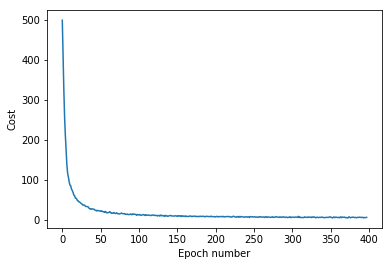

Accuracy: 0.995595


In [9]:
parameters = model(X_train, Y_train, layers_dims=[100, 50, 20], epochs=400, print_costs=True)

In [10]:
def predict(X_data, parameters):
    n_x = X_data.shape[0]
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    layers_dims = [n_x] + [50,25] + [10]
    Z = forward_propagation(X, parameters)
    Y = tf.argmax(Z)
    with tf.Session() as sess:
        predictions = sess.run(Y, feed_dict={X: X_data})
    return predictions

In [11]:
Y = predict(X_test, parameters)

In [12]:
Y = np.column_stack((np.arange(1, 28001), Y)).astype(int)
np.savetxt('submission.csv', Y, fmt='%i', header='ImageId,Label', comments='', delimiter=',')